# Data Preparation

In [1]:
import os
import numpy as np
from typing import Tuple, Dict, List
from tqdm import tqdm
import random

import torch
import torch.nn as nn 
from torch.nn import DataParallel
from torch.optim import Adam, Optimizer

from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
from PIL import Image

import matplotlib.pyplot as plt

from imagenette_dataset import ImageNetteDataset, train_val_split
from trainer import train
from models.ResNeXt import ResNeXt, ResNeXtBlock
from utils import get_random_images, plot_predictions, plot_confusion_matrix

In [2]:
def download_data():
    if not os.path.exists('data'):
        os.makedir('data')

    if not os.listdir('data'):
        !wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz
        !tar -xzvf 'imagenette2.tgz' -C 'data'

download_data()

In [3]:
random_seed = 0
np.random.seed(random_seed)
torch.manual_seed(random_seed)
random.seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device('cuda:7' if torch.cuda.is_available() else 'cpu')
device_ids = [7, 6, 5, 4, 3, 2, 1]
device

device(type='cuda', index=7)

In [4]:
train_dataset, val_dataset = train_val_split(
    ImageNetteDataset(root_dir='data/imagenette2/train'), 
    val_size=0.2)
test_dataset = ImageNetteDataset(root_dir='data/imagenette2/val')

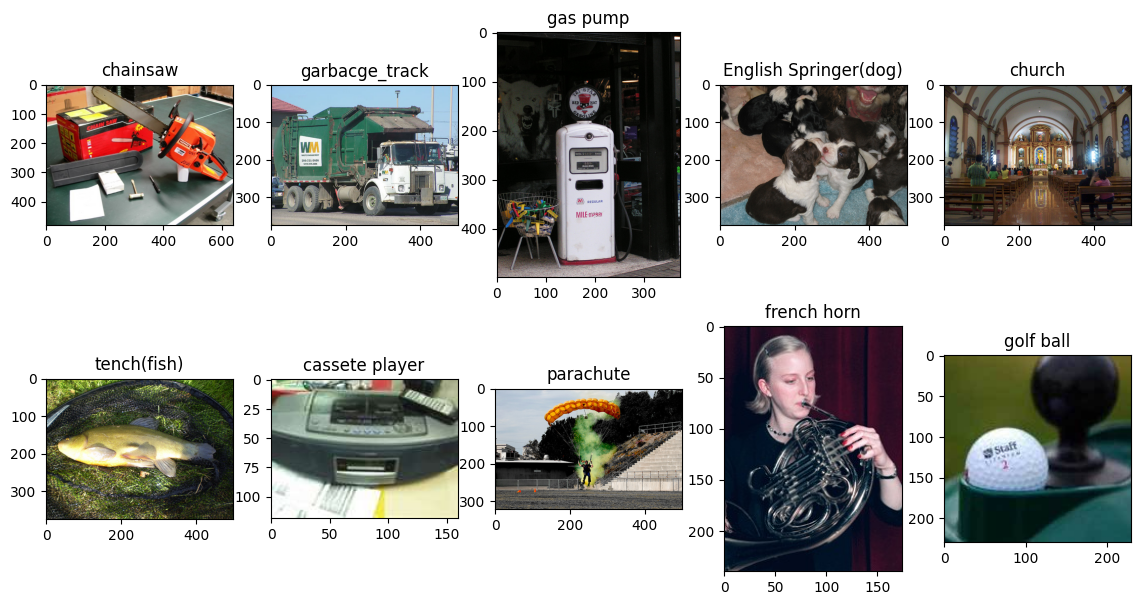

In [5]:
train_dataset.dataset.random_data_examples()

In [6]:
print(f'Train size = {len(train_dataset)}, Validation size = {len(val_dataset)}, Test size = {len(test_dataset)}')

Train size = 7575, Validation size = 1894, Test size = 3925


In [7]:
batch_size = 256
n_workers = 8

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=n_workers)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=n_workers)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=n_workers)

# Training

In [8]:
resnext_18 = DataParallel(ResNeXt(ResNeXtBlock, 
                                  cardinality=32, 
                                  width=4, 
                                  layers=[2, 2, 2, 2], 
                                  num_classes=10).to(device), 
                          device_ids=device_ids)
resnext_50 = DataParallel(ResNeXt(ResNeXtBlock,  
                                  cardinality=32, 
                                  width=4, 
                                  layers=[3, 4, 6, 3], 
                                  num_classes=10).to(device), 
                          device_ids=device_ids)
resnext_101 = DataParallel(ResNeXt(ResNeXtBlock, 
                                  cardinality=32, 
                                  width=4, 
                                  layers=[3, 4, 23, 3], 
                                  num_classes=10).to(device), 
                          device_ids=device_ids)

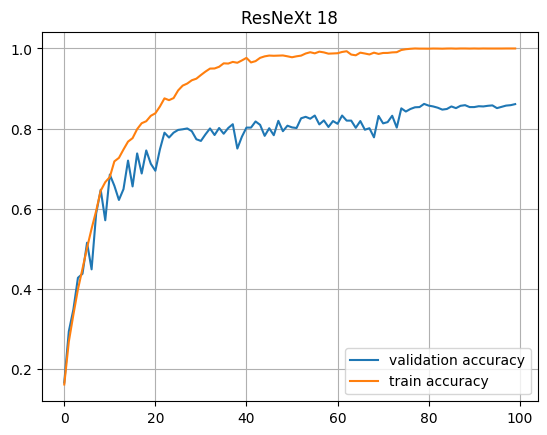

Validation accuracy: 0.861, best_val_acc: 0.862


Testing: 100%|██████████| 16/16 [00:06<00:00,  2.32it/s, accuracy=0.846]


Test accuracy of ResNeXt 18 = 0.8463694267515923


In [9]:
n_epochs = 100
lr= 5*1e-3

criterion = nn.CrossEntropyLoss()


optimizer = Adam(resnext_18.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, factor=0.5)
result_resnext_18 = train(resnext_18, 
                  train_dataloader, 
                  val_dataloader,
                  test_dataloader,
                  optimizer, 
                  criterion, 
                  device,
                  scheduler, 
                  n_epochs, 
                  title='ResNeXt 18')

del resnext_18
torch.cuda.empty_cache()

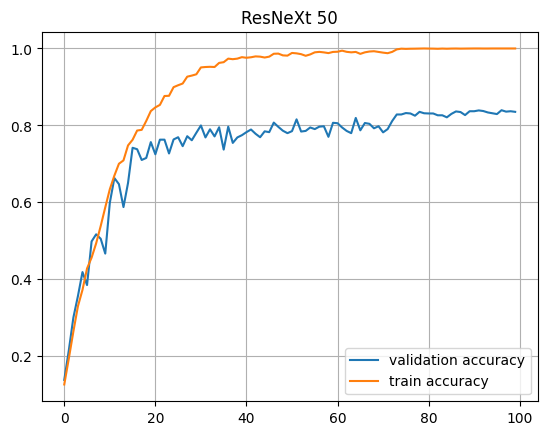

Validation accuracy: 0.835, best_val_acc: 0.839


Testing: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s, accuracy=0.821]


Test accuracy of ResNeXt 50 = 0.8214012738853503


In [10]:
optimizer = Adam(resnext_50.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, factor=0.5)
result_resnext_50 = train(resnext_50, 
                  train_dataloader, 
                  val_dataloader,
                  test_dataloader,
                  optimizer, 
                  criterion, 
                  device,
                  scheduler, 
                  n_epochs, 
                  title='ResNeXt 50')

del resnext_50
torch.cuda.empty_cache()

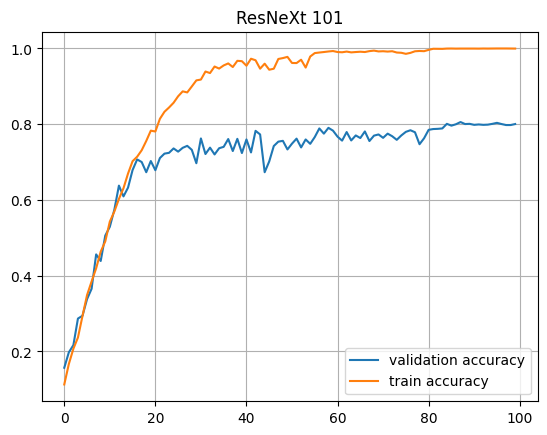

Validation accuracy: 0.800, best_val_acc: 0.806


Testing: 100%|██████████| 16/16 [00:06<00:00,  2.46it/s, accuracy=0.795]


Test accuracy of ResNeXt 101 = 0.7946496815286624


In [11]:
optimizer = Adam(resnext_101.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, factor=0.5)
result_resnext_101 = train(resnext_101, 
                  train_dataloader, 
                  val_dataloader,
                  test_dataloader,
                  optimizer, 
                  criterion, 
                  device,
                  scheduler, 
                  n_epochs, 
                  title='ResNeXt 101')

del resnext_101
torch.cuda.empty_cache()

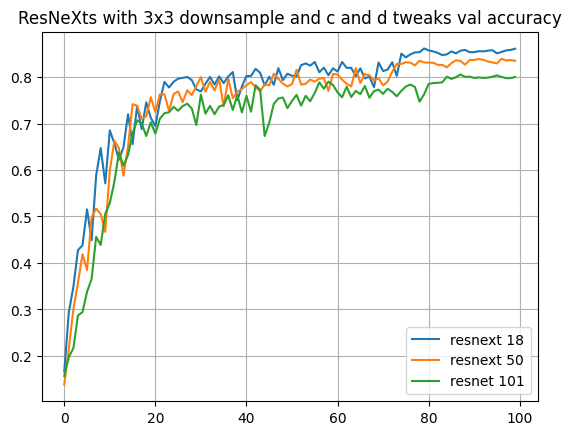

In [12]:
plt.plot(range(n_epochs), result_resnext_18['val_acc'], label='resnext 18')
plt.plot(range(n_epochs), result_resnext_50['val_acc'], label='resnext 50')
plt.plot(range(n_epochs), result_resnext_101['val_acc'], label='resnet 101')
plt.title(label='ResNeXts with 3x3 downsample and c and d tweaks val accuracy')
plt.grid()
plt.legend()
plt.show()

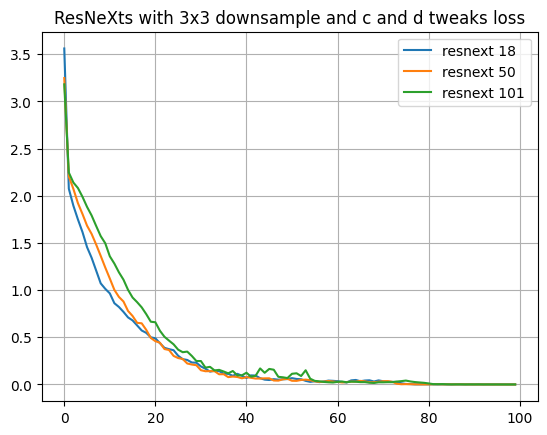

In [13]:
plt.plot(range(n_epochs), result_resnext_18['all_loss'], label='resnext 18')
plt.plot(range(n_epochs), result_resnext_50['all_loss'], label='resnext 50')
plt.plot(range(n_epochs), result_resnext_101['all_loss'], label='resnext 101')
plt.title(label='ResNeXts with 3x3 downsample and c and d tweaks loss')
plt.grid()
plt.legend()
plt.show()

In [15]:
test_acc_18 = result_resnext_18['test_acc']
test_acc_50 = result_resnext_50['test_acc']
test_acc_101 = result_resnext_101['test_acc']

print(f'Test accuracies \
      \nResNeXt 18: {test_acc_18} \
      \nResNeXt 50: {test_acc_50} \
      \nResNeXt 101: {test_acc_101}')

Test accuracies       
ResNeXt 18: 0.8463694267515923       
ResNeXt 50: 0.8214012738853503       
ResNeXt 101: 0.7946496815286624


In [17]:
torch.save(result_resnext_18['best_state'], 'resnext18.pt')
torch.save(result_resnext_50['best_state'], 'resnext50.pt')
torch.save(result_resnext_101['best_state'], 'resnext101.pt')

# Plot models predictions

In [16]:
images = get_random_images()

In [21]:
resnext_18 = DataParallel(ResNeXt(ResNeXtBlock, 
                                  cardinality=32, 
                                  width=4, 
                                  layers=[2, 2, 2, 2], 
                                  num_classes=10).to(device), 
                          device_ids=device_ids)
resnext_50 = DataParallel(ResNeXt(ResNeXtBlock,  
                                  cardinality=32, 
                                  width=4, 
                                  layers=[3, 4, 6, 3], 
                                  num_classes=10).to(device), 
                          device_ids=device_ids)
resnext_101 = DataParallel(ResNeXt(ResNeXtBlock, 
                                  cardinality=32, 
                                  width=4, 
                                  layers=[3, 4, 23, 3], 
                                  num_classes=10).to(device), 
                          device_ids=device_ids)

resnext_18.load_state_dict(torch.load('resnext18.pt'))
resnext_50.load_state_dict(torch.load('resnext50.pt'))
resnext_101.load_state_dict(torch.load('resnext101.pt'))

<All keys matched successfully>

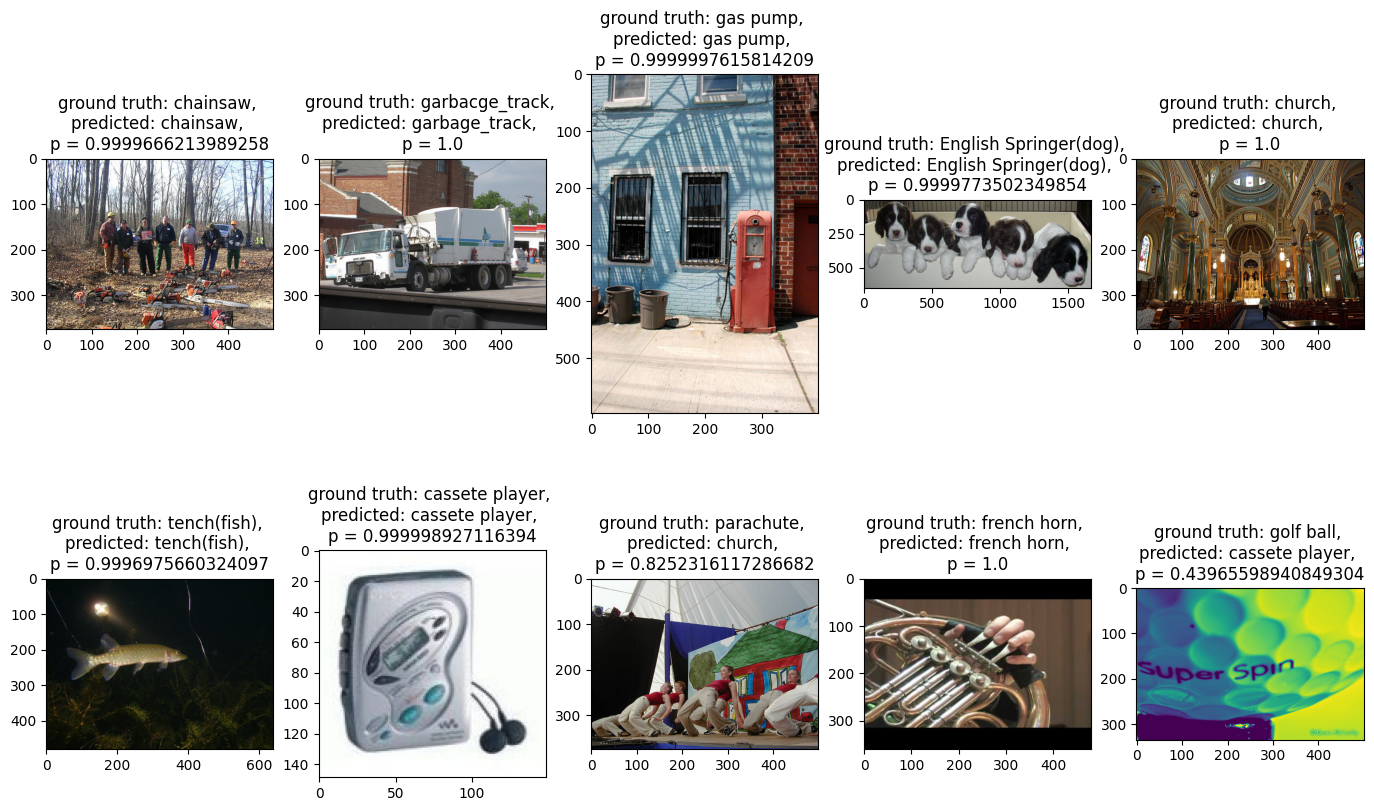

In [22]:
plot_predictions(resnext_18.module, images, device)

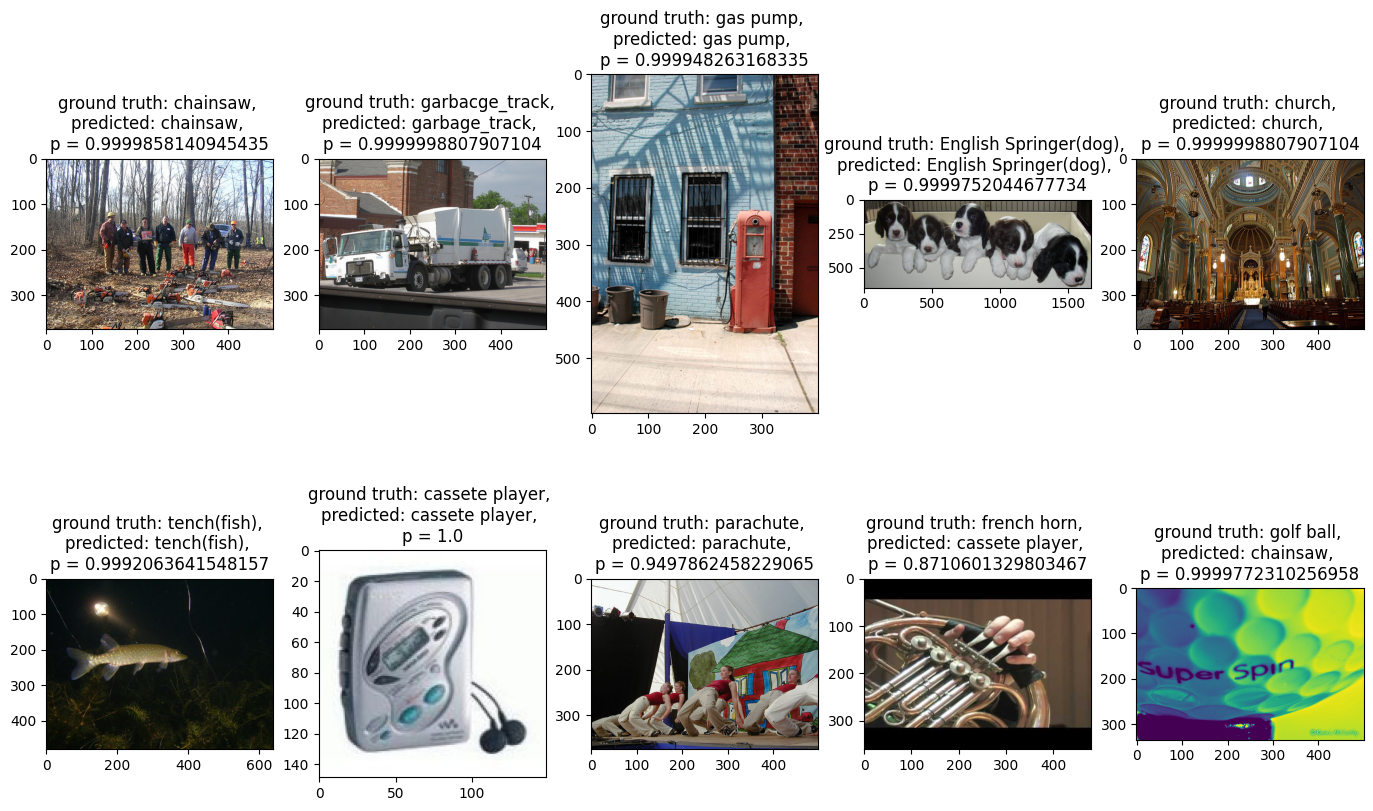

In [23]:
plot_predictions(resnext_50.module, images, device)

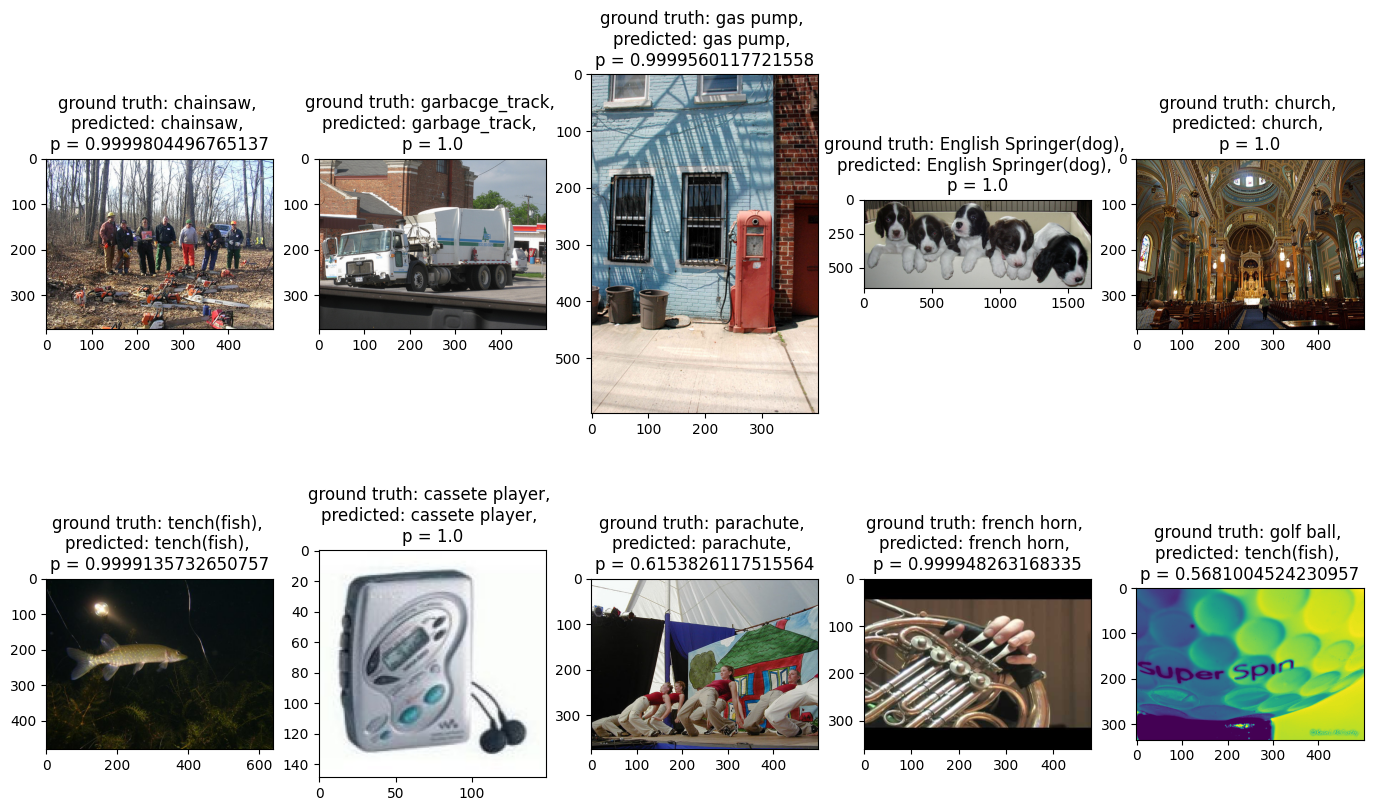

In [24]:
plot_predictions(resnext_101.module, images, device)